## Imports

In [1]:
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [2]:
!pip install -q umap-learn

In [1]:
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
import umap
from tqdm.auto import tqdm

manualSeed = 111

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import os


os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Data Loading: MNIST and Faces

In [3]:
!mkdir datasets

mkdir: datasets: File exists


In [4]:
BATCH_SIZE = 64
CIFAR_MEAN, CIFAR_STD = (0.5,), (0.5,)

mnist_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ]
)
mnist_train_dataset = datasets.MNIST(
    train=True,
    root="datasets/mnist_train/",
    transform=mnist_transforms,
    download=True
)
mnist_train_loader = DataLoader(
    mnist_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
mnist_val_dataset = datasets.MNIST(
    train=True,
    root="datasets/mnist_val/",
    transform=mnist_transforms,
    download=True
)
mnist_val_loader = DataLoader(
    mnist_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [5]:
## CelebA dataset: TODO
# Link: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg
# Link: https://pytorch.org/vision/0.15/generated/torchvision.datasets.CelebA.html

### Plot data

In [6]:
def denorm(img_tensors, mean, std):
    return img_tensors * std + mean


def show_images(images, mean, std, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(
        vutils.make_grid(
            denorm(
                images.detach()[:nmax],
                mean,
                std
            ),
            nrow=8
        ).permute(1, 2, 0)
    )


def show_batch(dl, mean, std, nmax=64):
    for images, _ in dl:
        show_images(images, mean, std, nmax)
        break

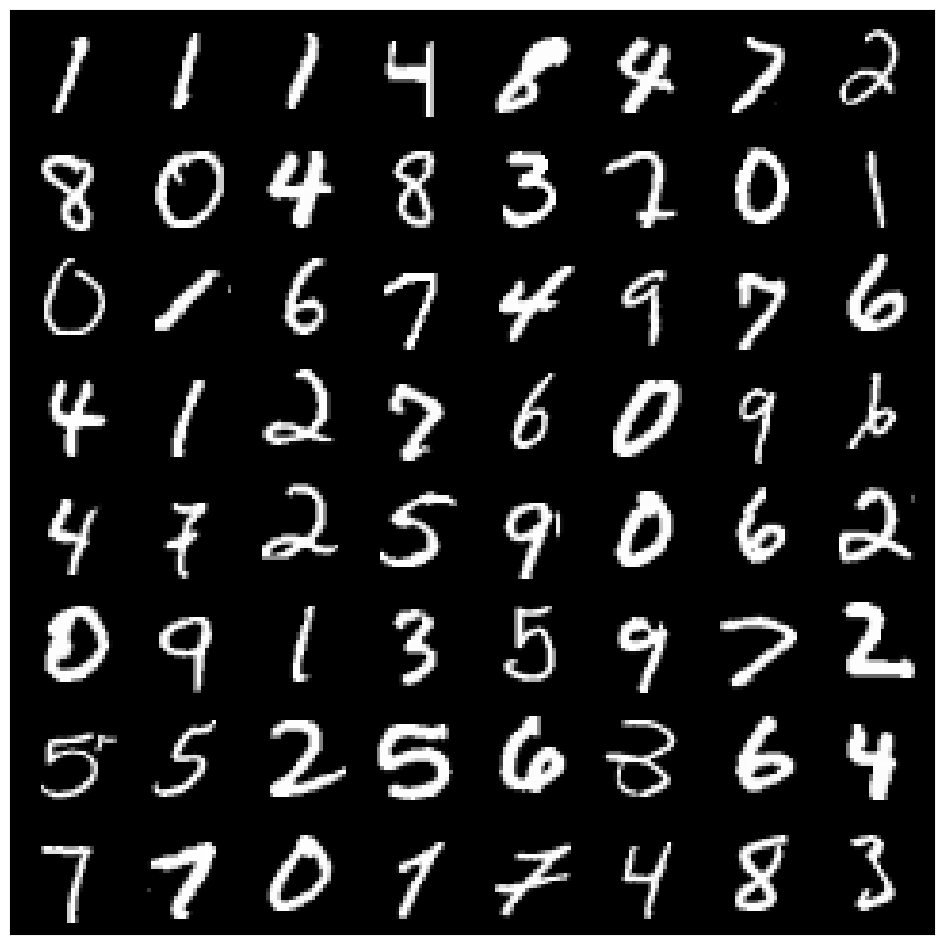

In [7]:
show_batch(mnist_train_loader, torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD))

## Encoders and decoders

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [8]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super().__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self.num_residual_layers = num_residual_layers

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        if num_residual_layers > 0:
            self._residual_stack = ResidualStack(
                in_channels=num_hiddens,
                num_hiddens=num_hiddens,
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=num_residual_hiddens
            )

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)

        if self.num_residual_layers > 0:
            return self._residual_stack(x)
        else:
            return x

In [10]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, out_channels):
        super().__init__()

        self.num_residual_layers = num_residual_layers

        self._conv_1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens,
            kernel_size=3,
            stride=1,
            padding=1
        )

        if num_residual_layers > 0:
            self._residual_stack = ResidualStack(
                in_channels=num_hiddens,
                num_hiddens=num_hiddens,
                num_residual_layers=num_residual_layers,
                num_residual_hiddens=num_residual_hiddens
            )

        self._conv_trans_1 = nn.ConvTranspose2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens//2,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self._conv_trans_2 = nn.ConvTranspose2d(
            in_channels=num_hiddens//2,
            out_channels=out_channels,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def forward(self, inputs):
        x = self._conv_1(inputs)

        if self.num_residual_layers > 0:
            x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

## VAE

Repo: https://github.com/pytorch/examples/tree/master/vae

**Question 2.** How to model VAE decoder $p(\boldsymbol{x} | \boldsymbol{z}, \theta)$? What does the decoder take as **input**? What is the **output** of the decoder?

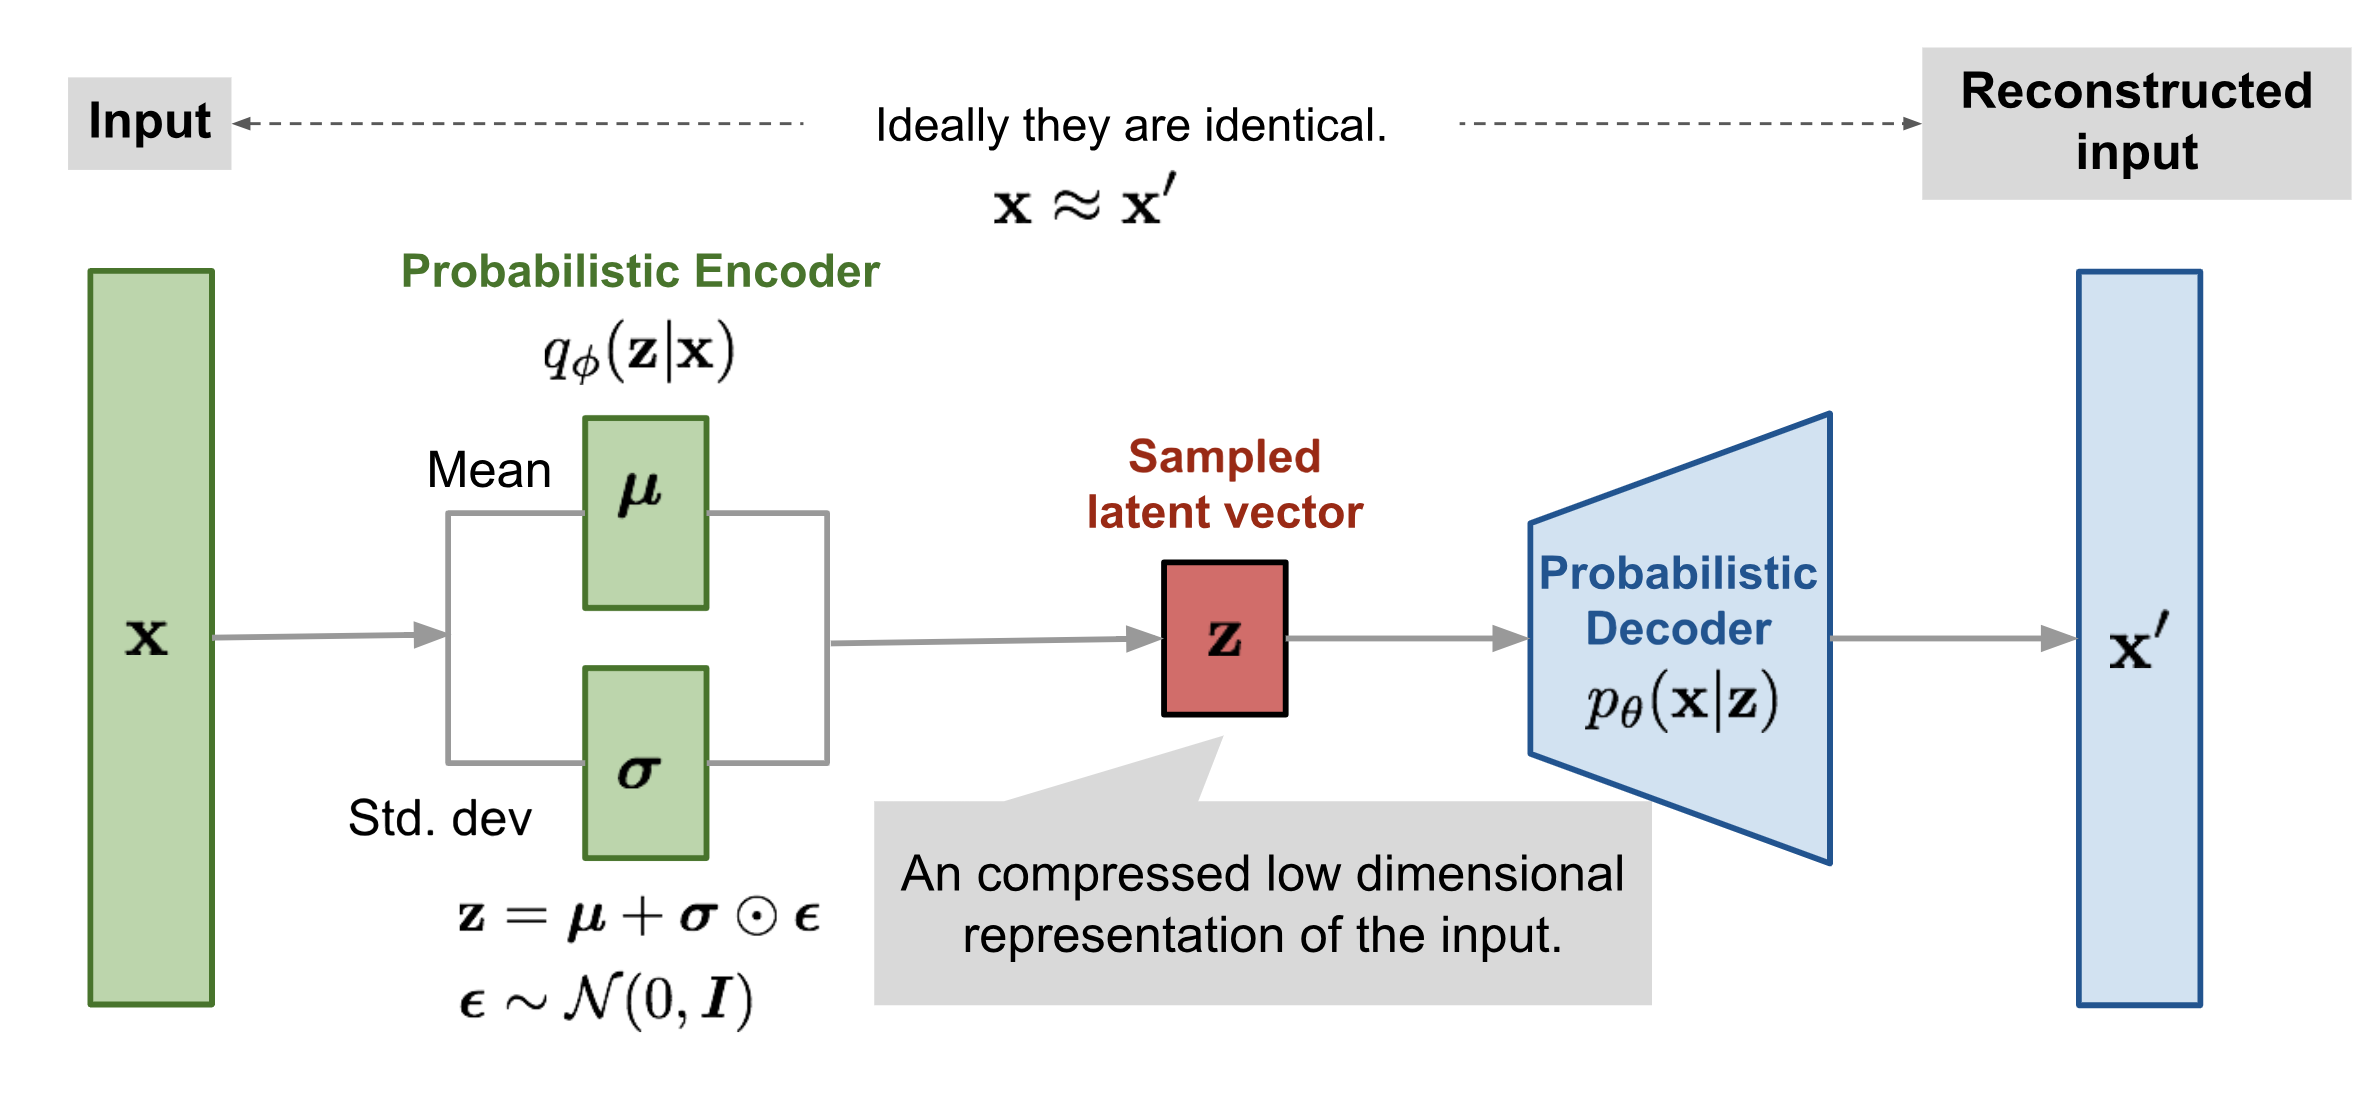

$x_1, \dots x_n$ is samples from unknown distribution $p(x)$

$$L(q, \theta) = \mathbb{E}_{z_1, \dots z_N \sim q(\boldsymbol{z}| \boldsymbol{x}, \phi)} \ln p(x_1, \dots x_N|\boldsymbol{z}, \theta) - KL(q(z_1, \dots, z_N| \boldsymbol{x}, \phi)||p(z_1, \dots , z_N))$$

**Questions:**

1. How to model VAE encoder $q(\boldsymbol{z} | \boldsymbol{x}, \phi)$??
2. How to model VAE decoder $p(\boldsymbol{x} | \boldsymbol{z}, \theta)$?
3. How to model $p(z)$? -- $\mathcal{N}(0, I)$
4. How to sample from VAE?

5. Which loss function are we optimizing? How do we optimize it?

6. What parameters do we optimize?

7. How does it relate to the EM algorithm?


We have samples $x_1, \dots x_N$ from unknown distribution $p(x)$.

1. Our optimal goal is to maximize **ELBO**:

    $$L(\phi, \theta) = \sum\limits_{n = 1}^{N} \left(\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) - KL(q(z_n| x_n, \phi)||p(z_n))\right)$$
    
   but we do it in a tricky way:
   
   * $p(z_n) = \mathcal{N}(0, I)$
   
   * $q(z_n| x_n, \phi) = \mathcal{N}\big{(}\mu_z(x_n|\phi), \text{diag}\left( \sigma^{(1)}_z(x_n| \phi), \dots \sigma^{(\text{z_dim})}_z(x_n | \phi)\right)\big{)}$
   
   * $\Rightarrow$ $KL(q(z_n| x_n, \phi)||p(z_n))$ has closed-form expression (as a function of $\mu_z(x_n|\phi), \boldsymbol{\sigma_z}(x_n | \phi)$)
   
   * $p(x_n | z_n, \theta) = $
       
       * $\mathcal{N}\big{(}\mu_x(z_n|\theta), \text{diag}\left( \sigma^{(1)}_x(z_n| \theta), \dots \sigma^{(\text{x_dim})}_x(z_n | \theta)\right)\big{)}$,
       
       * $\prod_{i=1}^D y_i^{x_i} (1 - y_i)^{1 - x_i}, \text{ where } \mathbf{y} = \sigma \bigl( \mathbf{W_2} \tanh (\mathbf{W_1} \mathbf{z} + \mathbf{b_1}) + \mathbf{b_2} \bigr)$
   
   * Then $\log p(x_n | z_n, \theta)$ lokks like L2 term (for 1st case) or BCE term (for 2nd case)
   
   * One-sample estimate of $\mathbb{E}_{z \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta)$ : 
   
   $$\mathbb{E}_{z_n \sim q(z_n| x_n, \phi)} \ln p(x_n|z_n, \theta) = \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I_{\text{z_dim}})} \log  p\big{(}x_n \big{|}\mu_z(x_n | \phi) + \boldsymbol{\sigma}_z(x_n | \phi) \odot \epsilon, \theta \big{|})} \approx\\ \approx \ln p\big{(} x_n \big{|} \mu_z(x_n | \phi) + \boldsymbol{\sigma}_z(x_n | \phi) \odot \epsilon_n, \theta\big{)}\, , \, \epsilon_n \sim \mathcal{N}(0, I_{\text{z_dim}})$$
 
 
2. We optimize ELBO with respect to both $\phi$ (decoder parameters) and $\theta$ (encoder parameters) 

3. The optimization procedure is actually **Variational EM** algorithm in a joint manner:

$$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}} \\
\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} L(q(\cdot| \boldsymbol{X}, \color{red}{\phi_{k}}), \theta)|_{\theta=\theta_{k}}$$

### Model

We will use simple MLP for encoder and decoder.

In [11]:
class VAE(nn.Module):
    """
    Variational AutoEncoder for MNIST
    """

    def __init__(self, kl_coef=1):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.kl_coef = kl_coef
        self.bce = 0
        self.kl = 0

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def sample(self, size):
        sample = torch.randn(size, 20)  # N(o, I)
        if self.cuda():
            sample = sample.cuda()
        sample = self.decode(sample).cpu()
        return sample

    def loss_function(self, x, recon_x, mu, logvar):
        self.bce = F.binary_cross_entropy(
            recon_x, (x.view(-1, 784) > 0).float(), reduction='sum')
        batch_size = x.size(0)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return (self.bce + self.kl_coef * self.kl) / batch_size

    def latest_losses(self):
        return {'bce': self.bce, 'kl': self.kl}

### Training pipeline

In [12]:
def train(model, dataloader, optimizer,
          train_history=None, valid_history=None, plot_step=100):
    model.train()

    epoch_loss = 0
    bce_history, kl_history, ttl_history = [], [], []

    for i, batch in enumerate(tqdm(dataloader)):
        inp, trg = batch
        inp = inp.to(DEVICE)
        trg = trg.to(DEVICE)
        optimizer.zero_grad()

        recon_inp, mu, logvar = model(inp)
        loss = model.loss_function(inp, recon_inp, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        ttl_history.append(loss.cpu().data.numpy())
        bce_history.append(model.latest_losses()['bce'].cpu().data.numpy())
        kl_history.append(model.latest_losses()['kl'].cpu().data.numpy())

        if (i + 1) % plot_step == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

            clear_output(True)
            ax[0].plot(ttl_history, label='total loss')
            ax[0].plot(bce_history, label='bce loss')
            ax[0].plot(kl_history, label='vq loss')

            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')

            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')

            ax[0].grid(True)
            ax[1].grid(True)
            ax[0].legend()
            ax[1].legend()
            plt.show()

    return epoch_loss / len(dataloader)


def evaluate(model, dataloader):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inp, trg = batch
            inp = inp.to(DEVICE)
            trg = trg.to(DEVICE)

            recon_inp, mu, logvar = model(inp)
            loss = model.loss_function(inp, recon_inp, mu, logvar)

            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
batch_size = 256
n_epochs = 1
learning_rate = 5e-4

vae_model = VAE(kl_coef=1.0).to(DEVICE)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate, amsgrad=False)

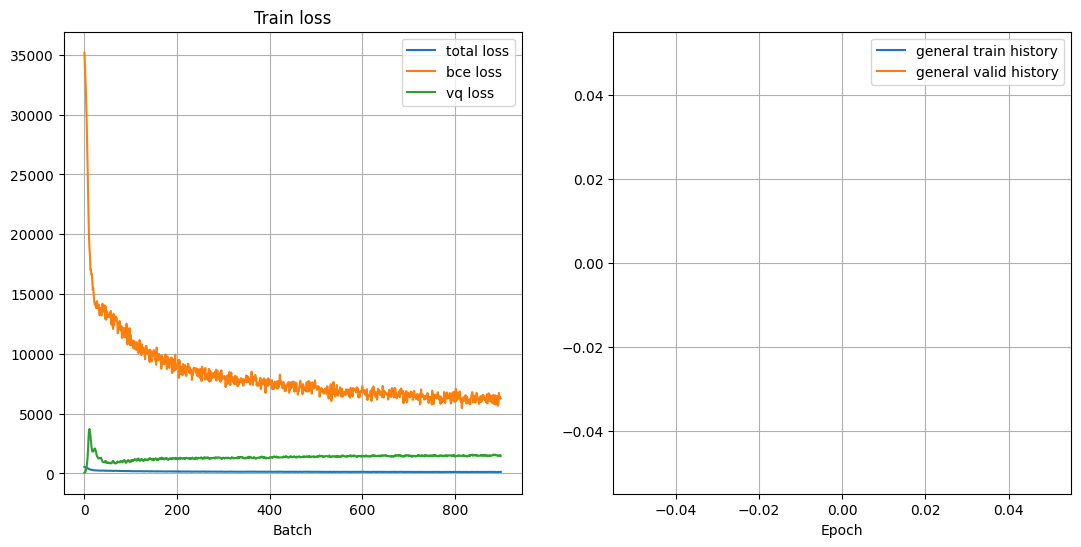

Epoch: 01 | Time: 0m 22s
	Train Loss: 149.338
	 Val. Loss: 110.412


In [14]:
train_history, val_history = [], []

for epoch in tqdm(range(n_epochs)):
    start_time = time.time()

    train_loss = train(vae_model, mnist_train_loader, optimizer, train_history, val_history)
    valid_loss = evaluate(vae_model, mnist_val_loader)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_history.append(train_loss)
    val_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

### Plot hidden representations

In [15]:
def plot_latent(autoencoder, data, num_batches=20):
    latents = []
    targets = []
    for i, (x, y) in enumerate(data):
        if i > num_batches:
            break

        mu, logvar = autoencoder.encode(x.to(DEVICE).view(-1, 784))
        z = autoencoder.reparameterize(mu, logvar)
        z = z.cpu().detach().numpy()
        latents.append(z)
        targets.append(y.numpy())

    latents = np.array(latents)
    targets = np.array(targets).reshape(-1)
    latents = latents.reshape(-1, latents.shape[-1])
    proj = umap.UMAP().fit_transform(latents)

    plt.scatter(proj[:, 0], proj[:, 1], c=targets, cmap='tab10')
    plt.colorbar()
    plt.show()

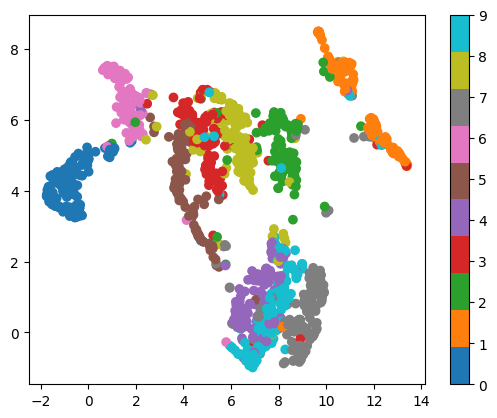

In [16]:
plot_latent(vae_model, mnist_train_loader, 20)

## VQ-VAE

Paper: https://arxiv.org/pdf/1711.00937.pdf  
Repo: https://github.com/nadavbh12/VQ-VAE/tree/master

### Vector Quantizer Layer

In [17]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg


# image = mpimg.imread("vq-vae.png")
# plt.figure(figsize=(12, 10))
# plt.imshow(image)
# plt.axis(False)
# plt.show()

In [18]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg


# image = mpimg.imread("vq-vae-minima.png")
# plt.figure(figsize=(12, 10))
# plt.imshow(image)
# plt.axis(False)
# plt.show()

**Reminder:**
* We define  dictionary (word book) space $\{\mathbf{e}_k\}_{k=1}^K$, where $\mathbf{e}_k \in \mathbb{R}^C$, $K$ is the size of the dictionary.
* $\mathbf{z}_e = \text{NN}_e(\mathbf{x}, \boldsymbol{\phi})$ - continuous output of encoder network.
* $\mathbf{z}_q = \mathbf{e}_{k^*}$ is a quantized representation, where $k^* = \text{argmin}_k \| \mathbf{z} - \mathbf{e}_k \|$. It is simple nearest neighbor look up.
* Out deterministic variational posterior:
$$
  q(c = k^* | \mathbf{x}, \boldsymbol{\phi}) = \begin{cases}
  1 , \quad \text{for } k^* = \text{argmin}_k \| \mathbf{z}_e - \mathbf{e}_k \|; \\
  0, \quad \text{otherwise}.
\end{cases}
$$
* Prior distribution is uniform: $p(c) = \text{Uniform}\{1, \dots, K\}$.
* KL divergence between posterior and prior:
$$
  KL(q(c = k^* | \mathbf{x}, \boldsymbol{\phi}), p(c)) = \log K.
$$
* ELBO:
$$
		\mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta})  = \mathbb{E}_{q(c | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{e}_{c} , \boldsymbol{\theta}) - \log K =  \log p(\mathbf{x} | \mathbf{z}_q, \boldsymbol{\theta}) - \log K.
$$
* Vector quantization is non-differentiable operation. We will use **straight-through** gradient estimator (we will copy gradients from decoder input $\mathbf{z}_q$ to encoder output $\mathbf{z}_e$.

**Important modifications:**
Due to the straight-through gradient estimation of mapping from $\mathbf{z}_e$ to $\mathbf{z}_q$, the embeddings $\mathbf{e} receive no gradients from the ELBO.

Therefore, in order to learn the embedding space we add l2 loss (**codebook loss**) to move the embedding vectors $\mathbf{e}$ towards the encoder outputs $\mathbf{z}_e$.

Finally, since the volume of the embedding space is dimensionless, it can grow arbitrarily if the embeddings $\mathbf{e}$ do not train as fast as the encoder parameters. To make sure the encoder commits to an embedding and its output does not grow, we add a **commitment loss**.

Thus, the total training objective becomes:
$$
  \log p(\mathbf{x}| \mathbf{z}_q, \boldsymbol{\theta}) + \| \text{sg}(\mathbf{z}_e) - \mathbf{e}\|_2^2 + \beta \| \mathbf{z}_e - \text{sg}(\mathbf{e})\|_2^2.
$$

Pay attention to the $\text{stop_gradient}(*)$ operator.


Only reconstruction loss isn't enough because in this scenario embeddings won't be trained

In [18]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()

        self._embedding_dim = embedding_dim
        # Dictionary size
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        # flat_input.shape = (B * H * W, C) = (N, C)
        # self._embedding.weight.shape = (num_emb, emb_dim) = (K, C)
        # distances = (N, K)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Argmin encoding
        # encoding_indices.shape = (N, 1)
        # encodings.shape = (N, K)
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        
        # encodings[i, encoding_indices[i, j]] = 1
        # torch.scatter_ docs:
        # https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html#torch.Tensor.scatter_
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        # (N, K) x (K, C) = (N, C) = (B * H * W, C) --> (B, H, W, C)
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        # Get the gradient to "skip" the quantization part
        # https://ai.stackexchange.com/questions/26770/in-vq-vae-code-what-does-this-line-of-code-signify
        quantized = inputs + (quantized - inputs).detach()
        # avg_proba.shape = (K,)
        avg_probs = torch.mean(encodings, dim=0)
        # perplexity = exp(H(p))
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

### Final model

In [19]:
class VQ_VAE(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost):
        super().__init__()

        self._encoder = Encoder(
            in_channels,
            num_hiddens,
            num_residual_layers,
            num_residual_hiddens
        )
        # bring the channels count to the embedding_dim
        self._pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=embedding_dim,
            kernel_size=1,
            stride=1
        )
        self._vec_quant = VectorQuantizer(
            num_embeddings,
            embedding_dim,
            commitment_cost
        )

        self._decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_residual_layers,
            num_residual_hiddens,
            in_channels
        )

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vec_quant(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity


    def sample(self):
        pass

### Training

In [20]:
batch_size = 256
n_epochs = 1

in_channels = 1
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

learning_rate = 5e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model = VQ_VAE(
    in_channels,
    num_hiddens,
    num_residual_layers,
    num_residual_hiddens,
    num_embeddings,
    embedding_dim,
    commitment_cost
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
recon_criterion = F.mse_loss

In [22]:
def train(model, dataloader, optimizer, recon_criterion,
          train_history=None, valid_history=None, plot_step=100):
    model.train()

    epoch_loss = 0
    recon_history, perplexity_history, vq_history = [], [], []
    ttl_history = []

    for i, batch in enumerate(tqdm(dataloader)):
        inp, trg = batch
        inp = inp.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(inp)
        # Here is reconstruction loss!
        recon_error = recon_criterion(data_recon, inp)
        loss = recon_error + vq_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        ttl_history.append(loss.cpu().data.numpy())
        recon_history.append(recon_error.cpu().data.numpy())
        perplexity_history.append(perplexity.cpu().data.numpy())
        vq_history.append(vq_loss.cpu().data.numpy())

        if (i + 1) % plot_step == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

            clear_output(True)
            ax[0].plot(recon_history, label='reconstruction loss')
            ax[0].plot(vq_history, label='vq loss')
            ax[0].plot(perplexity_history, label='perplexity')

            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')

            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')

            ax[0].grid(True)
            ax[1].grid(True)
            ax[0].legend()
            ax[1].legend()
            plt.show()

    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, recon_criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inp, trg = batch
            inp = inp.to(device)
            trg = trg.to(device)

            vq_loss, data_recon, perplexity = model(inp)
            recon_error = recon_criterion(data_recon, inp)
            loss = recon_error + vq_loss

            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

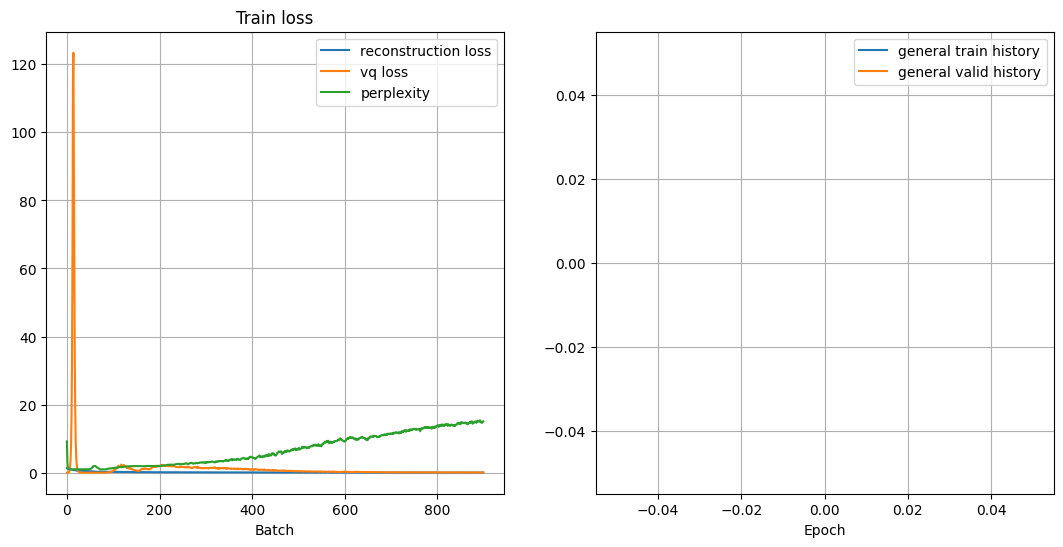

KeyboardInterrupt: 

In [26]:
train_history, val_history = [], []

for epoch in tqdm(range(n_epochs)):
    start_time = time.time()

    train_loss = train(model, mnist_train_loader, optimizer, recon_criterion, train_history, val_history)
    valid_loss = evaluate(model, mnist_val_loader, recon_criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_history.append(train_loss)
    val_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

### Validation

In [23]:
model.eval()

(valid_originals, _) = next(iter(mnist_val_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vec_quant(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22085744..1.3152837].


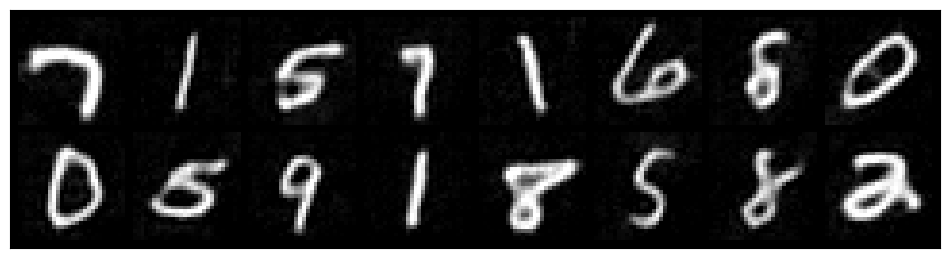

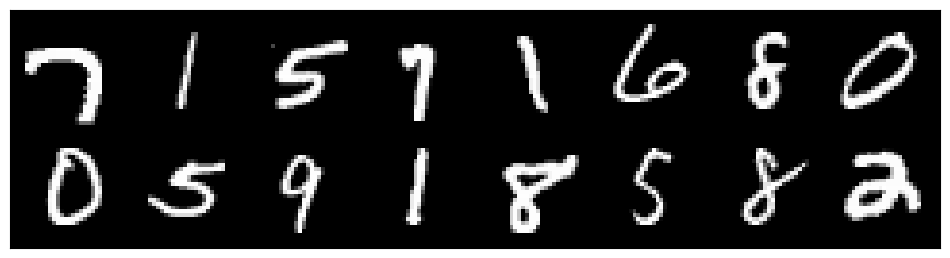

In [28]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


# Try show_batch
START_IND = 48
show_images(valid_reconstructions.cpu().data[START_IND:], torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD), 16)
show_images(valid_originals.cpu().data[START_IND:], torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD), 16)

Ввиду простоты данных, модель практически идеально восстанавливает картинки. Ммнорные деффекты видны у девятки в левом нижнем углу и у единички в середине верхнего ряда

### Plot hidden representations

In [29]:
def plot_latent(autoencoder, data, num_batches=20):
    latents = []
    targets = []
    for i, (x, y) in enumerate(data):
        if i >= num_batches:
            break

        z = autoencoder._encoder(x.to(DEVICE))
        z = autoencoder._pre_vq_conv(z)
        _, quantized, _, _ = autoencoder._vec_quant(z)
        quantized = quantized.cpu().detach().numpy()
        latents.append(quantized)
        targets.append(y.numpy())

    # latents.shape = (num_batches, batch_size, emb_dim, H', W') =: (nb, bs, emb, H', W')
    # targets.shape = (num_batches, batch_size)
    latents = np.array(latents)
    targets = np.array(targets).reshape(-1)

    # (nb, bs, emb, H', W') --> (nb * bs, H' * W' * emb)
    latents = latents.reshape(latents.shape[0] * latents.shape[1], -1)
    proj = umap.UMAP(min_dist=0.1, metric='cosine').fit_transform(latents)

    plt.scatter(proj[:, 0], proj[:, 1], c=targets, cmap='tab10')
    plt.colorbar()
    plt.show()

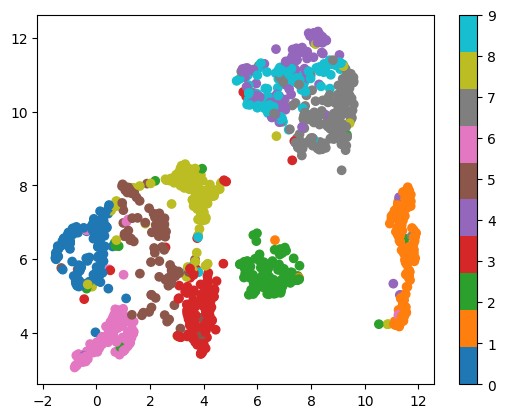

In [30]:
plot_latent(model, mnist_train_loader)

### Visualizing the discrete codes

Интересное наблюдение -- первый квантированный элемент визуально схож с исходной картинкой

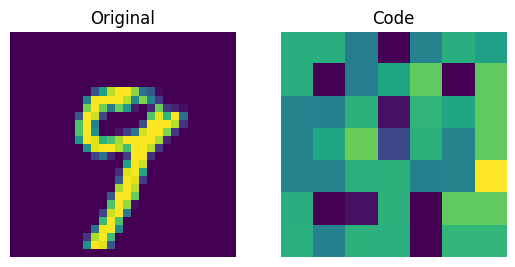

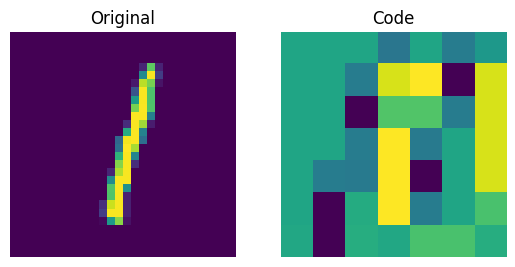

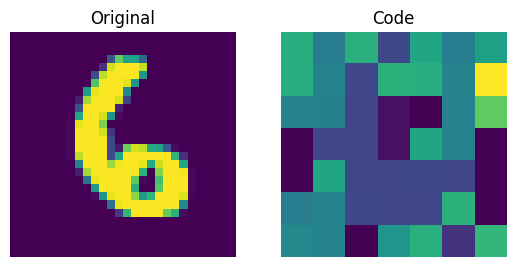

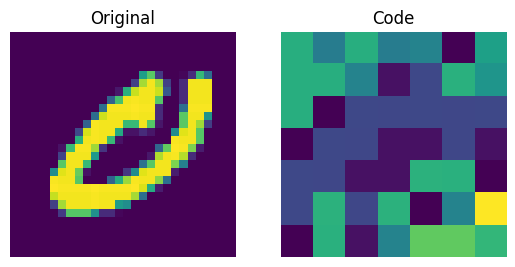

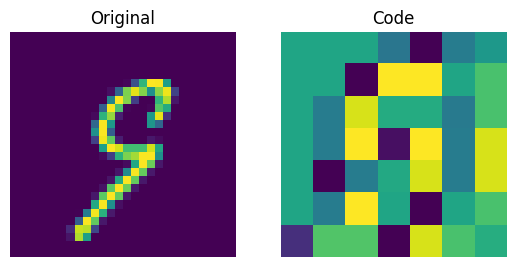

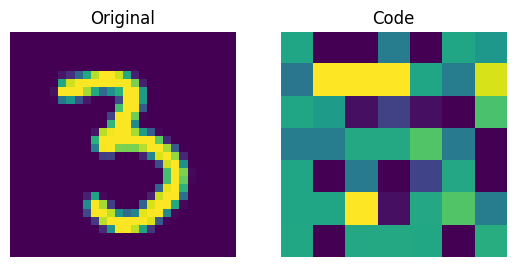

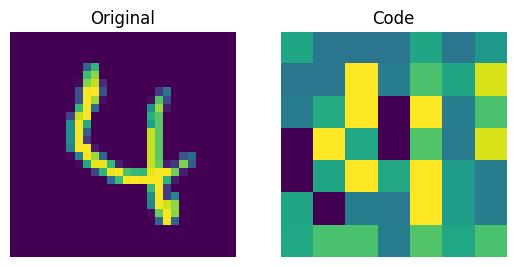

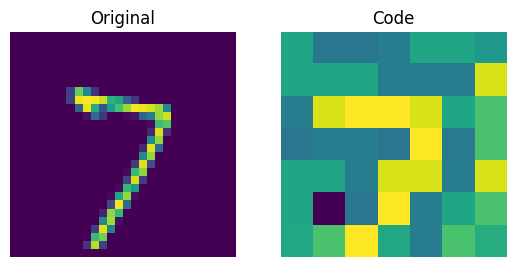

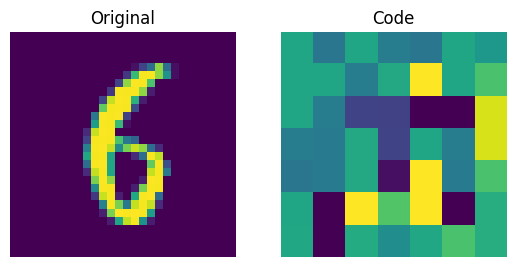

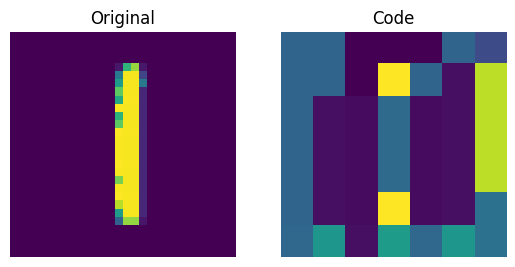

In [31]:
model.eval()
test_images = valid_originals.to(DEVICE)[10:20]

# test_images.shape = (8, 1, 28, 28)
# encoded_outputs.shape = (8, 64, H', W'), where H' = W' = 7
# quantized.shape = (0, 64, H', W'), where H' = W' = 7
encoded_outputs = model._pre_vq_conv(model._encoder(test_images))
_, quantized, _, _ = model._vec_quant(encoded_outputs)

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].cpu().squeeze() * CIFAR_STD[0] + CIFAR_MEAN[0])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(quantized[i][0].cpu().detach().numpy())
    plt.title("Code")
    plt.axis("off")
    plt.show()